In [2]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

### Assumptions

1. No vapour holdup in column
2. Constant liquid holdup on each plate
3. Constant holdup in condenser
4. Constant holdup in reboiler
5. Equilibrium data is obtained through the use of relative volatility
6. Feed enters column as saturated liquid
7. Plates are assumed to be 100% efficient
8. No entrainment or weeping occurs

### Manipulated variables

1. Feed on plate 3
2. Feed on plate 7
3. Composition of the feed stream
4. Reflux ratio
5. Holdup in condenser
6. Holdup in reboiler
7. Holdup on each tray
8. Relative volatility



In [13]:
# Initialize Model
m = GEKKO()

# Define constants

#Reflux Ratio
rr=m.Param(value=0.6)

# Feed flowrate (mol/min)
Feed1=m.Const(value=1)
Feed2=m.Const(value=0)

# Mole fraction of feed
x_Feed=m.Const(value=.25)

#Relative volatility = (yA/xA)/(yB/xB) = KA/KB = alpha(A,B)
vol=m.Const(value=1.6)

# Total molar holdup on each tray
atray=m.Const(value=.20)

# Total molar holdup in condenser
acond=m.Const(value=.15)

# Total molar holdup in reboiler
areb=m.Const(value=.45)


# mole fraction of component A
x=[]
for i in range(12):
    x.append(m.Var(.1))


# Define intermediates

# Distillate flowrate (mol/min)
D=m.Intermediate(0.5)

# Liquid flowrate in rectification section (mol/min)
L=m.Intermediate(rr*D)

# Vapor Flowrate in column (mol/min)
V=m.Intermediate(L+D)

# Liquid flowrate in stripping section (mol/min)
FL1=m.Intermediate(Feed1+L)
FL2=m.Intermediate(FL1+Feed2)

# vapor mole fraction of Component A
# From the equilibrium assumption and mole balances
# 1) vol = (yA/xA) / (yB/xB)
# 2) xA + xB = 1
# 3) yA + yB = 1
y=[]
for i in range(12):
    y.append(m.Intermediate(x[i]*vol/(1+(vol-1)*x[i])))

# Differential equations

# condenser
m.Equation(acond*x[0].dt()==V*(y[1]-x[0]))

# 2 column stages
n=1
for i in range(2):
    m.Equation(atray * x[n].dt() ==L*(x[n-1]-x[n]) - V*(y[n]-y[n+1]))
    n=n+1

# feed tray 3
m.Equation(atray * x[3].dt() == Feed1*x_Feed + L*x[2] - FL1*x[3] - V*(y[3]-y[4]))

# 3 column stages
n=4
for i in range(3):
    m.Equation(atray * x[n].dt() == FL1*(x[n-1]-x[n]) - V*(y[n]-y[n+1]))
    n=n+1
    
# feed tray 7
m.Equation(atray * x[7].dt() == Feed1*x_Feed + L*x[6] - FL2*x[7] - V*(y[7]-y[8]))    

n=8
for i in range(3):
    m.Equation(atray * x[n].dt() == FL2*(x[n-1]-x[n]) - V*(y[n]-y[n+1]))
    n=n+1

# reboiler
m.Equation(areb  * x[11].dt() == FL2*x[10] - (Feed1+Feed2-D)*x[11] - V*y[11])

# steady state solution

m.solve()
print(x) # with RR=0.7

# switch to dynamic simulation


m.options.imode=4
nt = 1000
m.time=np.linspace(0,15,1000)

# step change in reflux ratio

rr_step = np.ones(nt) * 0.6
#rr_step[10:] = 60
rr.value=rr_step
sol = m.solve()
sol

apm 197.185.104.20_gk_model6 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            7
   Variables    :           13
   Intermediates:           17
   Connections  :            0
   Equations    :           29
   Residuals    :           12
 
 Number of state variables:             12
 Number of total equations: -           12
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program co

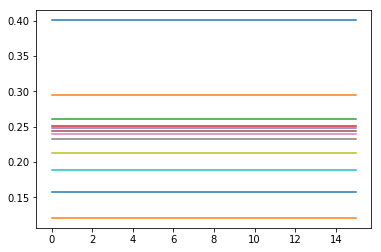

0.400839905


In [15]:
for i in range(12):
    plt.plot(m.time,x[i].value,label='x{}'.format(i))

plt.show()
print(x[0].value[-1])